In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import sympy as sy
import time
from pycqed import *

def diff2(sweep,dep,ind,var={}):
    xy, z, v = hamil.getSweep(sweep,[dep,ind],var)
    ret = []
    for i in range(len(xy[1])):
        ret.append(np.gradient(np.gradient(z[0,i,:],xy[0][1]-xy[0][0],edge_order=2),xy[0][1]-xy[0][0],edge_order=2)[1])
    return np.array(ret)

# Averin Coupler Study

Here we simulate the the Averin coupler circuit for creating a variable electrostatic coupling between qubits. First we look at the isolated coupler and compare with the results presented in Averin's paper.

## Isolated Coupler

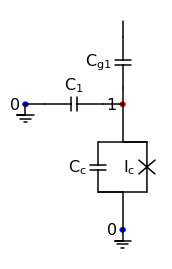

In [2]:
circuit = CircuitSpec("Averin Coupler")
circuit.addBranch(["Cc","Ic"],"up",0,False,lead_len=1.5)
circuit.addBranch(["C1"],"left",1,True)
circuit.addChargeBias('up',1,lead_len=1)
circuit.drawCircuit(inline=True)

The capacitance $C_1$ is included to account for any capacitive loading by external circuits, including stray capacitance to the island. $C_{g1}$ represents the gate capacitance, but it could be lumped into $C_1$.

The circuit Hamiltonian here is as follows:

In [3]:
circuit.getQuantumHamiltonian()

Matrix([[-0.5*I_{c}*(1.0*D^{\dagger}_{1} + 1.0*D_{1}) + 0.5*(Q_{1e} + Q_{1})**2/(C_{1} + C_{c} + C_{g1})]])

The charging energy at node 1 is:

In [4]:
Ec = circuit.getSingleParticleChargingEnergies()[1]
display(Ec)

2.0*e**2/(C_{1} + C_{c} + C_{g1})

The Josephson energy of the single JJ is:

In [5]:
Ej = circuit.getJosephsonEnergies()[(0,1)]
display(Ej)

I_{c}*\Phi_0/(2*pi)

We know from Averin _et al_ that to maximize the electrostatic coupling, we need to maximize the ratio of the charging energy to the Josephson energy, this can the be expressed as:

In [6]:
display(Ec/Ej)

4.0*pi*e**2/(I_{c}*\Phi_0*(C_{1} + C_{c} + C_{g1}))

Where it is clear that both the junction critical current and all the capacitances have to be minimized.

Now we express the degrees of freedom of the circuit in the charge basis, since there are no inductors we cannot use an oscillator basis. We can use a high truncation for the single mode since it is not demanding computationally:

In [7]:
hamil = HamilSpec(circuit,mode="node")
hamil.setTruncation(1,20,"charge")
hamil.prepareOperators()
hamil.params.getParameterNamesList()

Using existing PyCQED tmp output root directory '/tmp/.pycqed/'.


['Cc', 'Ic', 'C1', 'Cg1', 'Q1e']

Now we set the circuit parameter values and determine the Hamiltonian at half a Cooper pair charge:

In [8]:
# Fabrication parameters
Ca = 60.0 # fF/um^2
Jc = 2.0  # uA/um^2
Aj = 0.15*0.1#0.4**2 # um^2

# Parameter initial values
myvalues = {
    "Cc":Ca*Aj,
    "Ic":Jc*Aj,
    "C1":.5,
    "Cg1":5,
    "Q1e":0.5
}

# Do the substitution
hamil.substitute(myvalues)

In [9]:
H = hamil.getHamiltonian()
display(H)

Quantum object: dims = [[41], [41]], shape = (41, 41), type = oper, isherm = True
Qobj data =
[[4603.45605891   -7.45025272    0.         ...    0.
     0.            0.        ]
 [  -7.45025272 4143.41311285   -7.45025272 ...    0.
     0.            0.        ]
 [   0.           -7.45025272 3707.58295343 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ... 4143.41311285
    -7.45025272    0.        ]
 [   0.            0.            0.         ...   -7.45025272
  4603.45605891   -7.45025272]
 [   0.            0.            0.         ...    0.
    -7.45025272 5087.7117916 ]]

The minimum gap is just the difference between the first excited and ground states:

In [10]:
E = H.eigenenergies()
E[1]-E[0]

13.65944389445884

Here we see that the minimum energy gap is high enough to not interact significantly with flux qubits used in QA, which typically are operated with energy scales under 10 GHz.

Now we look at the energy spectrum as a function of the external gate charge, induced through the gate capacitance $C_{g1}$. During the sweep we can evaluate the charging energy of node 1 and the Josephson energy of the junction on branch (0,1):

In [11]:
# Configure the sweep
spec = [
    hamil.sweepSpec('Ic',Jc*Aj/2,Jc*Aj*2,4),
    hamil.sweepSpec('Q1e',-1.0,1.0,101)
]

# Configure the items to be evaluated
evals = [
    hamil.evalSpec('getHamiltonian',True,None),
    hamil.evalSpec('getChargingEnergies',False,None,node=1),
    hamil.evalSpec('getJosephsonEnergies',False,None,edge=(0,1))
]

sweep = hamil.paramSweep(spec,eval_spec=evals)

Now lets plot the energy gap spectrum and the ground state side-by-side:

Text(0.5, 1.0, 'Ground State')

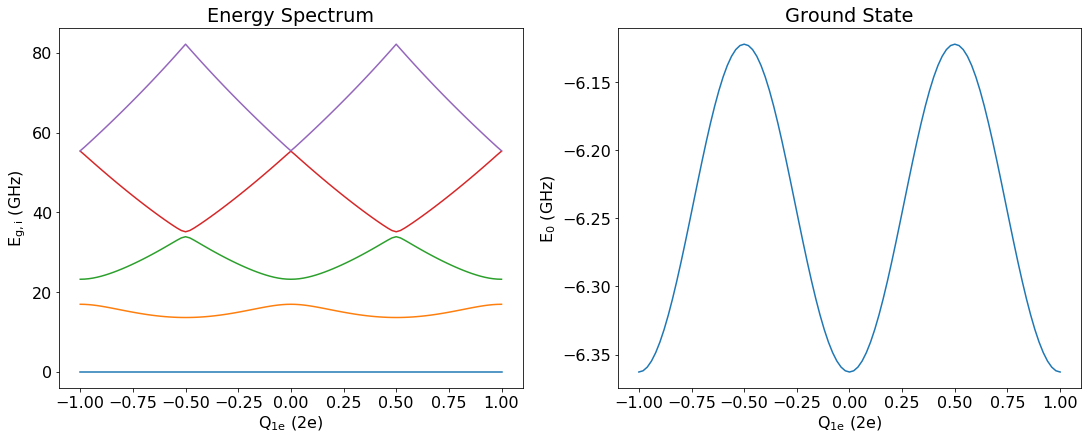

In [12]:
# Get the sweep for a high value of Ic
x,Q1e_sweep,v = hamil.getSweep(sweep,'Q1e',{'Ic':Jc*Aj})

fig, ax = plt.subplots(ncols=2,nrows=1,constrained_layout=True,figsize=(15,6))
ax1 = ax[0]
ax2 = ax[1]

# Energy spectrum
for i in range(5):
    y = Q1e_sweep[i]-Q1e_sweep[0]
    ax1.plot(x,y)
ax1.set_xlabel("$Q_{1e}$ ($2e$)")
ax1.set_ylabel("$E_{g,i}$ (GHz)")
ax1.set_title("Energy Spectrum")

# Ground state
y = Q1e_sweep[0]
ax2.plot(x,y)
ax2.set_xlabel("$Q_{1e}$ ($2e$)")
ax2.set_ylabel("$E_{0}$ (GHz)")
ax2.set_title("Ground State")

As can be seen, the ground state energy varies very little, and thus the variation in the coupling energy will be very small. Let's now look at the ratio between the charging energy and Josephson energy:

In [13]:
# Get the sweep for a single value of flux
x,Ec_sweep,v = hamil.getSweep(sweep,'Ic',{'Q1e':0.5},evaluable="getChargingEnergies")
x,Ej_sweep,v = hamil.getSweep(sweep,'Ic',{'Q1e':0.5},evaluable="getJosephsonEnergies")

In [14]:
EcEj = Ec_sweep/Ej_sweep
EcEj

array([1.62496411, 0.81248206, 0.5416547 , 0.40624103])

Indeed we see that for a small ratio, the ground state should have an almost sinusoidal shape as observed.

Now if we plot the second derivative of the ground state against the gate charge, we can compare the results quantitavely:

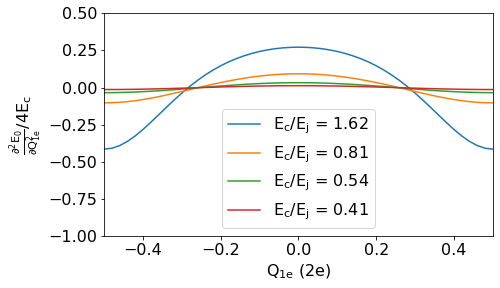

In [15]:
# Get the sweep
for i,Ic in enumerate(hamil.getParameterSweep('Ic')):
    x,y,v = hamil.getSweep(sweep,'Q1e',{'Ic':Ic})
    myvalues['Ic'] = Ic
    dy = np.gradient(np.gradient(y[0],x[1]-x[0],edge_order=2),x[1]-x[0],edge_order=2)/(Ec_sweep[i]*4)
    plt.plot(x,dy,label="$E_c/E_j$ = %.2f" % (EcEj[i]))
plt.xlabel("$Q_{1e}$ ($2e$)")
plt.ylabel("$\\frac{\\partial^2 E_{0}}{\\partial Q_{1e}^2} / 4E_c$")
plt.xlim(-0.5,0.5)
plt.ylim(-1.0,0.5)
plt.legend()

We find that the coupling strength roughly matches that presented in FIG. 3 of Averin's paper.

We see that for a large ratio of $E_c$ to $E_j$, we can get a coupling strength that approaches the order of magnitude of the charging energy.

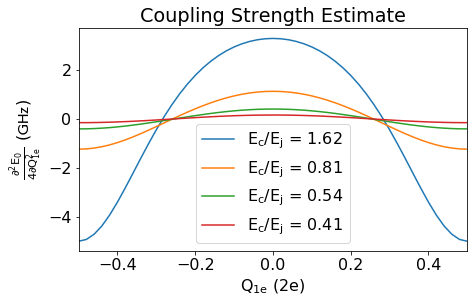

In [16]:
# Get the sweep
for i,Ic in enumerate(hamil.getParameterSweep('Ic')):
    x,y,v = hamil.getSweep(sweep,'Q1e',{'Ic':Ic})
    myvalues['Ic'] = Ic
    dy = np.gradient(np.gradient(y[0],x[1]-x[0],edge_order=2)/4,x[1]-x[0],edge_order=2)
    plt.plot(x,dy,label="$E_c/E_j$ = %.2f" % (EcEj[i]))
plt.xlabel("$Q_{1e}$ ($2e$)")
plt.ylabel("$\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}$ ($\\mathrm{GHz}$)")
plt.xlim(-0.5,0.5)
plt.title("Coupling Strength Estimate")
#plt.ylim(-1.0,0.5)
plt.legend()

This implies that huge coupling energies can be achieved, however in practice there will many more capacitances connected to node 1, which will significantly decrease this energy, and in turn require the Josephson energy to decrease also.

Now lets look at the coupler minimum gap as a function of this ratio:

In [17]:
# Configure the sweep
spec = [
    hamil.sweepSpec('Ic',Jc*Aj*0.1,Jc*Aj*10,100),
    hamil.sweepSpec('C1',0,10,3)
]

# Configure the items to be evaluated
evals = [
    hamil.evalSpec('getHamiltonian',True,None),
    hamil.evalSpec('getChargingEnergies',False,None,node=1),
    hamil.evalSpec('getJosephsonEnergies',False,None,edge=(0,1))
]

# Set some parameters
hamil.setParameterValue('Q1e',0.5)

sweep = hamil.paramSweep(spec,eval_spec=evals)

# Get the sweep for a single value of flux
x,Ec_sweep1,v = hamil.getSweep(sweep,'Ic',{'C1':0},evaluable="getChargingEnergies")
x,Ej_sweep1,v = hamil.getSweep(sweep,'Ic',{'C1':0},evaluable="getJosephsonEnergies")
x,Ec_sweep2,v = hamil.getSweep(sweep,'Ic',{'C1':5},evaluable="getChargingEnergies")
x,Ej_sweep2,v = hamil.getSweep(sweep,'Ic',{'C1':5},evaluable="getJosephsonEnergies")
x,Ec_sweep3,v = hamil.getSweep(sweep,'Ic',{'C1':10},evaluable="getChargingEnergies")
x,Ej_sweep3,v = hamil.getSweep(sweep,'Ic',{'C1':10},evaluable="getJosephsonEnergies")

# Get energy ratio
EcEj1 = Ec_sweep1/Ej_sweep1
EcEj2 = Ec_sweep2/Ej_sweep2
EcEj3 = Ec_sweep3/Ej_sweep3

# Get the sweep for a high value of Ic
x,Ic_sweep1,v = hamil.getSweep(sweep,'Ic',{'C1':0})
x,Ic_sweep2,v = hamil.getSweep(sweep,'Ic',{'C1':5})
x,Ic_sweep3,v = hamil.getSweep(sweep,'Ic',{'C1':10})

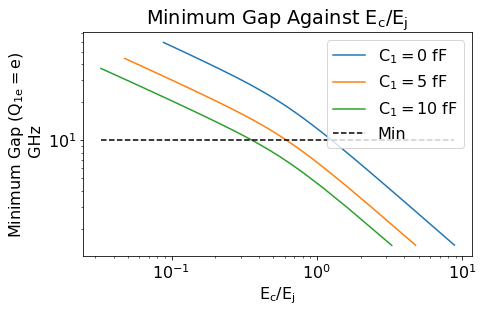

In [18]:
plt.plot(EcEj1,Ic_sweep1[1]-Ic_sweep1[0],label="$C_1 = 0$ fF")
plt.plot(EcEj2,Ic_sweep2[1]-Ic_sweep2[0],label="$C_1 = 5$ fF")
plt.plot(EcEj3,Ic_sweep3[1]-Ic_sweep3[0],label="$C_1 = 10$ fF")
plt.plot([EcEj3[-1],EcEj1[0]],[10,10],"k--",label="Min")
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$E_c/E_j$')
plt.ylabel('Minimum Gap ($Q_{1e}=e$)\n GHz')
plt.title('Minimum Gap Against $E_c/E_j$')
plt.legend(loc=1)

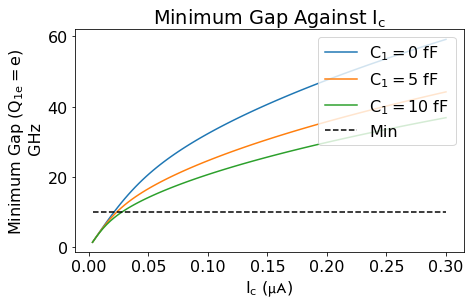

In [19]:
plt.plot(x,Ic_sweep1[1]-Ic_sweep1[0],label="$C_1 = 0$ fF")
plt.plot(x,Ic_sweep2[1]-Ic_sweep2[0],label="$C_1 = 5$ fF")
plt.plot(x,Ic_sweep3[1]-Ic_sweep3[0],label="$C_1 = 10$ fF")
plt.plot([x[0],x[-1]],[10,10],"k--",label="Min")
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('$I_c$ ($\\mathrm{\mu A}$)')
plt.ylabel('Minimum Gap ($Q_{1e}=e$)\n GHz')
plt.title('Minimum Gap Against $I_c$')
plt.legend(loc=1)

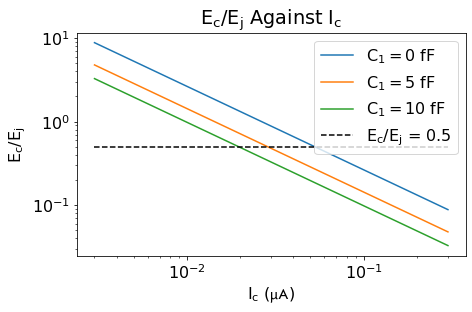

In [20]:
plt.plot(x,EcEj1,label="$C_1 = 0$ fF")
plt.plot(x,EcEj2,label="$C_1 = 5$ fF")
plt.plot(x,EcEj3,label="$C_1 = 10$ fF")
plt.plot([x[0],x[-1]],[0.5,0.5],"k--",label="$E_c/E_j$ = 0.5")
plt.plot([])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$I_c$ ($\\mathrm{\mu A}$)')
plt.ylabel('$E_c/E_j$')
plt.title('$E_c/E_j$ Against $I_c$')
plt.legend(loc=1)

## Coupler Fabrication Parameters

Now we can consider what we encounter in practice, by expressing the various circuit parameters in terms of fabrication parameters.

In [21]:
# Create new symbols
Jc, Ca, lse, l1 = sy.symbols("J_c C_a w_{se} w_1")

# Add the parameters
name_map = {
    "Jc":Jc,
    "Ca":Ca,
    "lse":lse,
    "l1":l1
}

# Replace capacitors
hamil.addParameterisation("Cc",lse*l1*Ca,name_map)

# Replace JJs
hamil.addParameterisation("Ic",lse*l1*Jc,name_map)


In [22]:
hamil.params_subs['Ic']

J_c*w_1*w_{se}

We need to regenerate the operators and matrix expressions following a parameterisation:

In [23]:
hamil.prepareOperators()
hamil.params.getParameterNamesList()

['Cc', 'Ic', 'C1', 'Cg1', 'Q1e', 'Jc', 'Ca', 'lse', 'l1']

Now lets compute the ratio of the charging energy to the Josephson energy with the new added terms.

In [24]:
Ec = hamil.getSymbolicChargingEnergies(node=1)
Ej = hamil.getSymbolicJosephsonEnergies(edge=(0,1))
(Ec/Ej)

4.0*pi*e**2/(J_c*\Phi_0*w_1*w_{se}*(C_a*w_1*w_{se} + C_{1} + C_{g1}))

Now lets sweep some of the circuit parameters that are critical to the coupling strength, we can first look at the dependence of the coupling strength near half a Cooper pair bias:

In [25]:
hamil.setParameterValues('lse',0.1,'l1',0.15,'Ca',60,'Jc',3,'Cg1',1.0,'C1',10)
spec = [
    hamil.sweepSpec('Q1e',0.499,0.501,3),
    hamil.sweepSpec('C1',3,17,4),
    hamil.sweepSpec('Jc',0.1,10.0,101)
]

# Configure the items to be evaluated
evals = [
    hamil.evalSpec('getHamiltonian',True,None),
    hamil.evalSpec('getChargingEnergies',False,None,node=1),
    hamil.evalSpec('getJosephsonEnergies',False,None,edge=(0,1))
]

st = time.time()
sweep = hamil.paramSweep(spec,eval_spec=evals,timesweep=True)

Parameter Sweep Duration:
  Initialization:	0.010 s
  Loop duration:	9.109 s
  Avg iteration:	0.008 s


In [26]:
print ("Cc = %.3f fF" % (hamil.getParameterValue('Ca')*hamil.getParameterValue('lse')*hamil.getParameterValue('l1')))

Cc = 0.900 fF


In [27]:
# Take the second derivative of ground state against Jc and l1 points
Cpl_e = []
for l1 in hamil.getParameterSweep('C1'):
    xy, z, v = hamil.getSweep(sweep,['Jc','Q1e'],{'C1':l1})
    Cpl1 = []
    for i in range(len(xy[1])):
        Cpl1.append(np.gradient(np.gradient(z[0,i,:],xy[0][1]-xy[0][0],edge_order=2),xy[0][1]-xy[0][0],edge_order=2)[1])
    Cpl_e.append(np.array(Cpl1))

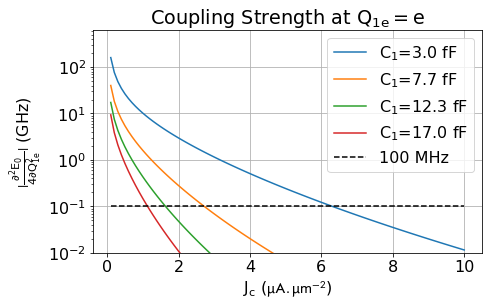

In [28]:
plt.title("Coupling Strength at $Q_{1e} = e$")
for i,Cpl1 in enumerate(Cpl_e):
    plt.plot(xy[1],np.abs(Cpl1)/4,label="$C_1$=%.1f fF" % (hamil.getParameterSweep('C1')[i]))
plt.plot([xy[1][0],xy[1][-1]],[0.1,0.1],"k--",label="100 MHz")
plt.yscale('log')
plt.xlabel("$J_c$ $(\\mathrm{\mu A.\mu m^{-2}})$")
plt.ylabel("$\\left|\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}\\right|$ (GHz)")
plt.ylim((0.01,abs(Cpl_e[0][0])))
plt.legend()
plt.grid()

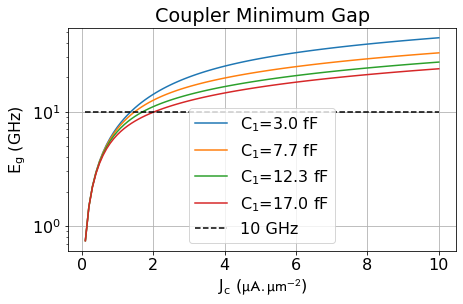

In [29]:
# Take the second derivative of ground state against Jc and l1 points
Gap_e = []
for l1 in hamil.getParameterSweep('C1'):
    x, z, v = hamil.getSweep(sweep,'Jc',{'C1':l1,'Q1e':0.5})
    Gap_e.append(np.array(z[1]-z[0]))

plt.title("Coupler Minimum Gap")
for i,l1 in enumerate(hamil.getParameterSweep('C1')):
    plt.plot(x,Gap_e[i],label="$C_{1}$=%.1f fF" % (l1))
plt.plot([x[0],x[-1]],[10,10],"k--",label="10 GHz")
plt.yscale('log')
plt.xlabel("$J_c$ $(\\mathrm{\mu A.\mu m^{-2}})$")
plt.ylabel("$E_g$ (GHz)")
plt.legend()
plt.grid()

### Regions of Interest

We can plot both the coupler strength and minimum gap on the same plot to define a region of interest. The idea is to maximise the coupling strength whilst maintaining a high enough minimum gap to avoid interfering with the computational subspace in a qubit system that uses this coupler.

We therefore set two conditions that must be simultaneously satisfied:
- The minimum acceptable coupling strength is 100 MHz
- The minimum gap cannot go below 10 GHz

__The black dotted line represents both conditions above.__

__As long as the intercept of like-coloured lines is above the black dotted line, there exists a region of interest for the parameter of the X-axis.__

__The coupler gap curves are represented by dashed lines.__

__The maximum coupling achievable is that found at the parameter value for which the (dashed) coupler gap curve intersects the black dotted line.__

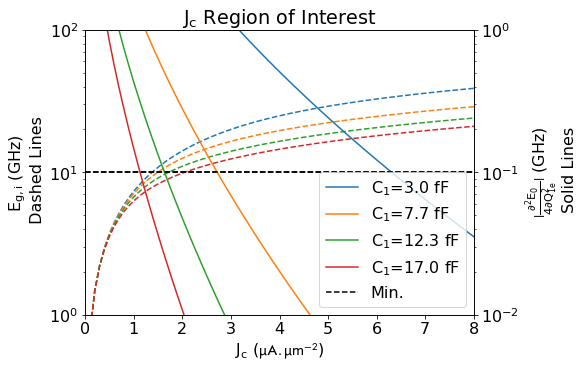

In [30]:
fig, ax1 = plt.subplots(ncols=1,nrows=1,constrained_layout=True,figsize=(8,5))
xran = (0,8)

# Energy spectrum
ax1.plot(x,Gap_e[0],linestyle='dashed',label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[0]))
ax1.plot(x,Gap_e[1],linestyle='dashed',label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[1]))
ax1.plot(x,Gap_e[2],linestyle='dashed',label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[2]))
ax1.plot(x,Gap_e[3],linestyle='dashed',label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[3]))
ax1.plot(xran,[10,10],"k--")
ax1.set_xlabel("$J_c$ $(\\mathrm{\mu A.\mu m^{-2}})$")
ax1.set_ylabel("$E_{g,i}$ (GHz)\n Dashed Lines")
ax1.set_title("$J_c$ Region of Interest")
ax1.set_yscale('log')
ax1.set_ylim((1,100))

ax11 = ax1.twinx()
ax11.plot(x,np.abs(Cpl_e[0])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[0]))
ax11.plot(x,np.abs(Cpl_e[1])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[1]))
ax11.plot(x,np.abs(Cpl_e[2])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[2]))
ax11.plot(x,np.abs(Cpl_e[3])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[3]))
ax11.plot(xran,[0.1,0.1],"k--",label="Min.")
ax11.set_ylabel("$\\left|\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}\\right|$ (GHz)\n Solid Lines")
ax11.set_yscale('log')
ax11.set_ylim((1e-2,1))
ax1.set_xlim(xran)
ax11.legend(loc=4)

In [31]:
x,Ec_sweep1,v = hamil.getSweep(sweep,'Jc',{'C1':3,'Q1e':0.5},evaluable="getChargingEnergies")
x,Ej_sweep1,v = hamil.getSweep(sweep,'Jc',{'C1':3,'Q1e':0.5},evaluable="getJosephsonEnergies")
x,Ec_sweep2,v = hamil.getSweep(sweep,'Jc',{'C1':8,'Q1e':0.5},evaluable="getChargingEnergies")
x,Ej_sweep2,v = hamil.getSweep(sweep,'Jc',{'C1':8,'Q1e':0.5},evaluable="getJosephsonEnergies")
x,Ec_sweep3,v = hamil.getSweep(sweep,'Jc',{'C1':12,'Q1e':0.5},evaluable="getChargingEnergies")
x,Ej_sweep3,v = hamil.getSweep(sweep,'Jc',{'C1':12,'Q1e':0.5},evaluable="getJosephsonEnergies")
x,Ec_sweep4,v = hamil.getSweep(sweep,'Jc',{'C1':17,'Q1e':0.5},evaluable="getChargingEnergies")
x,Ej_sweep4,v = hamil.getSweep(sweep,'Jc',{'C1':17,'Q1e':0.5},evaluable="getJosephsonEnergies")

# Get energy ratio
EcEj1 = Ec_sweep1/Ej_sweep1
EcEj2 = Ec_sweep2/Ej_sweep2
EcEj3 = Ec_sweep3/Ej_sweep3
EcEj4 = Ec_sweep4/Ej_sweep4

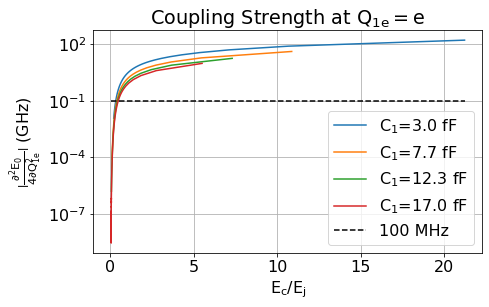

In [32]:
plt.title("Coupling Strength at $Q_{1e} = e$")
plt.plot(EcEj1,np.abs(Cpl_e[0])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[0]))
plt.plot(EcEj2,np.abs(Cpl_e[1])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[1]))
plt.plot(EcEj3,np.abs(Cpl_e[2])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[2]))
plt.plot(EcEj4,np.abs(Cpl_e[3])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[3]))
plt.plot([EcEj4[-1],EcEj1[0]],[0.1,0.1],"k--",label="100 MHz")
plt.yscale('log')
plt.xlabel("$E_c/E_j$")
plt.ylabel("$\\left|\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}\\right|$ (GHz)")
#plt.ylim((0.01,abs(Cpl_e[0][0])))
plt.legend()
plt.grid()

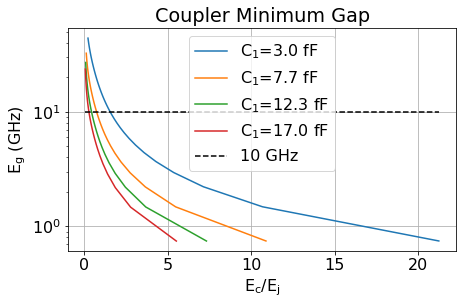

In [33]:
# Take the second derivative of ground state against Jc and l1 points
Gap_e = []
for l1 in hamil.getParameterSweep('C1'):
    x, z, v = hamil.getSweep(sweep,'Jc',{'C1':l1,'Q1e':0.5})
    Gap_e.append(np.array(z[1]-z[0]))

plt.title("Coupler Minimum Gap")
plt.plot(EcEj1,Gap_e[0],label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[0]))
plt.plot(EcEj2,Gap_e[1],label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[1]))
plt.plot(EcEj3,Gap_e[2],label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[2]))
plt.plot(EcEj4,Gap_e[3],label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[3]))
plt.plot([EcEj4[-1],EcEj1[0]],[10,10],"k--",label="10 GHz")
plt.yscale('log')
plt.xlabel("$E_c/E_j$")
plt.ylabel("$E_g$ (GHz)")
plt.legend()
plt.grid()

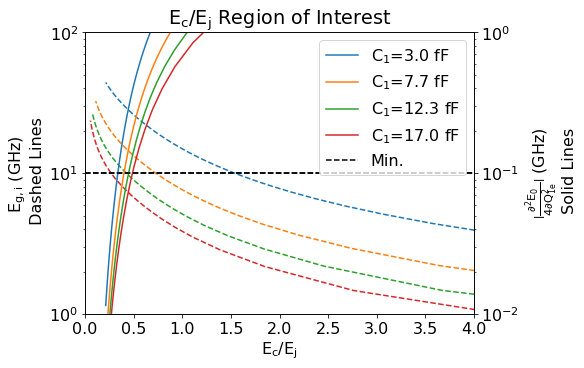

In [34]:
fig, ax1 = plt.subplots(ncols=1,nrows=1,constrained_layout=True,figsize=(8,5))
xran = (0,4)

# Energy spectrum
ax1.plot(EcEj1,Gap_e[0],linestyle='dashed',label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[0]))
ax1.plot(EcEj2,Gap_e[1],linestyle='dashed',label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[1]))
ax1.plot(EcEj3,Gap_e[2],linestyle='dashed',label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[2]))
ax1.plot(EcEj4,Gap_e[3],linestyle='dashed',label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[3]))
ax1.plot(xran,[10,10],"k--")
ax1.set_xlabel("$E_c/E_j$")
ax1.set_ylabel("$E_{g,i}$ (GHz)\n Dashed Lines")
ax1.set_title("$E_c/E_j$ Region of Interest")
ax1.set_yscale('log')
ax1.set_ylim((1,100))

ax11 = ax1.twinx()
ax11.plot(EcEj1,np.abs(Cpl_e[0])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[0]))
ax11.plot(EcEj2,np.abs(Cpl_e[1])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[1]))
ax11.plot(EcEj3,np.abs(Cpl_e[2])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[2]))
ax11.plot(EcEj4,np.abs(Cpl_e[3])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[3]))
ax11.plot(xran,[0.1,0.1],"k--",label="Min.")
ax11.set_ylabel("$\\left|\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}\\right|$ (GHz)\n Solid Lines")
ax11.set_yscale('log')
ax11.set_ylim((1e-2,1))
ax1.set_xlim(xran)
ax11.legend(loc=0)

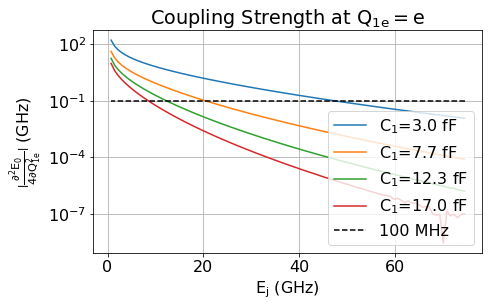

In [35]:
plt.title("Coupling Strength at $Q_{1e} = e$")
plt.plot(Ej_sweep1,np.abs(Cpl_e[0])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[0]))
plt.plot(Ej_sweep2,np.abs(Cpl_e[1])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[1]))
plt.plot(Ej_sweep3,np.abs(Cpl_e[2])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[2]))
plt.plot(Ej_sweep4,np.abs(Cpl_e[3])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[3]))
plt.plot([Ej_sweep3[-1],Ej_sweep1[0]],[0.1,0.1],"k--",label="100 MHz")
plt.yscale('log')
plt.xlabel("$E_j$ (GHz)")
plt.ylabel("$\\left|\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}\\right|$ (GHz)")
#plt.ylim((0.01,abs(Cpl_e[0][0])))
plt.legend(loc=4)
plt.grid()

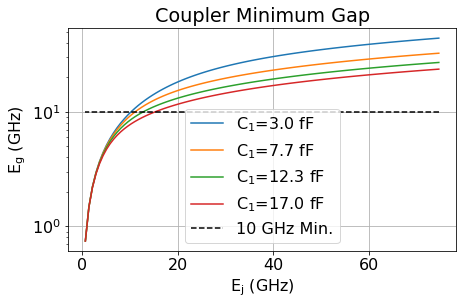

In [36]:
# Take the second derivative of ground state against Jc and l1 points
Gap_e = []
for l1 in hamil.getParameterSweep('C1'):
    x, z, v = hamil.getSweep(sweep,'Jc',{'C1':l1,'Q1e':0.5})
    Gap_e.append(np.array(z[1]-z[0]))

plt.title("Coupler Minimum Gap")
plt.plot(Ej_sweep1,Gap_e[0],label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[0]))
plt.plot(Ej_sweep2,Gap_e[1],label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[1]))
plt.plot(Ej_sweep3,Gap_e[2],label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[2]))
plt.plot(Ej_sweep4,Gap_e[3],label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[3]))
plt.plot([Ej_sweep4[-1],Ej_sweep1[0]],[10,10],"k--",label="10 GHz Min.")
plt.yscale('log')
plt.xlabel("$E_j$ (GHz)")
plt.ylabel("$E_g$ (GHz)")
plt.legend()
plt.grid()

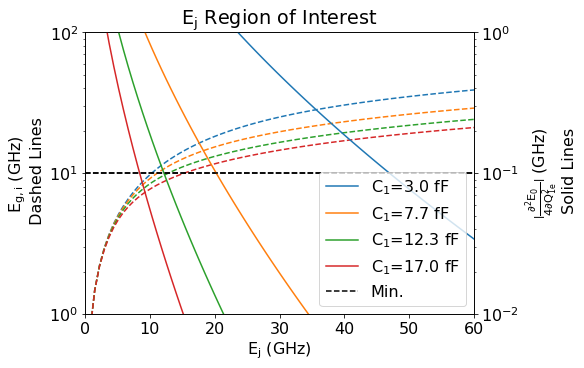

In [37]:
fig, ax1 = plt.subplots(ncols=1,nrows=1,constrained_layout=True,figsize=(8,5))
xran = (0,60)

# Energy spectrum
ax1.plot(Ej_sweep1,Gap_e[0],linestyle='dashed',label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[0]))
ax1.plot(Ej_sweep2,Gap_e[1],linestyle='dashed',label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[1]))
ax1.plot(Ej_sweep3,Gap_e[2],linestyle='dashed',label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[2]))
ax1.plot(Ej_sweep4,Gap_e[3],linestyle='dashed',label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[3]))
ax1.plot(xran,[10,10],"k--")
plt.xlabel("$E_j$ (GHz)")
ax1.set_ylabel("$E_{g,i}$ (GHz)\n Dashed Lines")
ax1.set_title("$E_j$ Region of Interest")
ax1.set_yscale('log')
ax1.set_ylim((1,100))

ax11 = ax1.twinx()
ax11.plot(Ej_sweep1,np.abs(Cpl_e[0])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[0]))
ax11.plot(Ej_sweep2,np.abs(Cpl_e[1])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[1]))
ax11.plot(Ej_sweep3,np.abs(Cpl_e[2])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[2]))
ax11.plot(Ej_sweep4,np.abs(Cpl_e[3])/4,label="$C_{1}$=%.1f fF" % (hamil.getParameterSweep('C1')[3]))
ax11.plot(xran,[0.1,0.1],"k--",label="Min.")
ax11.set_ylabel("$\\left|\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}\\right|$ (GHz)\n Solid Lines")
ax11.set_yscale('log')
ax11.set_ylim((1e-2,1))
ax1.set_xlim(xran)
ax11.legend(loc=4)

## Tunable Junction

Now we select a range of parameters that are in the region of interest, and replace the single junction with a perfectly symmetric DC-SQUID.

In [38]:
# Create new symbols
phie = sy.symbols("\\Phi_e")

# Add the parameter
name_map = {
    "phie":phie
}
expr = sy.cos(sy.pi*phie)*hamil.all_params_sym["Jc"]*hamil.all_params_sym["lse"]*hamil.all_params_sym["l1"]
hamil.addParameterisation("Ic",expr,name_map)

# Update the Hamiltonian components
hamil.prepareOperators()

# Show the updated parameter list and inverse capacitance matrix
display(hamil.params.getParameterNamesList())
display(hamil.Jvec)

['Cc', 'Ic', 'C1', 'Cg1', 'Q1e', 'Jc', 'Ca', 'lse', 'l1', 'phie']

Matrix([
[J_c*w_1*w_{se}*cos(pi*\Phi_e)],
[                            0]])

In [39]:
hamil.params_subs

{'Cc': C_a*w_1*w_{se}, 'Ic': J_c*w_1*w_{se}*cos(pi*\Phi_e)}

In [40]:
hamil.setParameterValues('lse',0.1,'l1',0.15,'Ca',60,'Jc',1.5,'Cg1',1,'C1',7.7,'Q1e',0.5,'phie',0.0)

# Configure the sweep
spec = [
    hamil.sweepSpec('Q1e',-1.0,1.0,101)
]

# Configure the items to be evaluated
evals = [
    hamil.evalSpec('getHamiltonian',True,None),
    hamil.evalSpec('getChargingEnergies',False,None,node=1),
    hamil.evalSpec('getJosephsonEnergies',False,None,edge=(0,1))
]

sweep = hamil.paramSweep(spec,eval_spec=evals)

In [41]:
x,Q1e_sweep,v = hamil.getSweep(sweep,'Q1e',{})

Text(0, 0.5, '$E_i$ (GHz)')

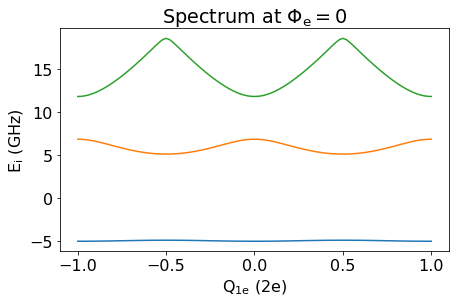

In [42]:
for i in range(3):
    plt.plot(x,Q1e_sweep[i]-Q1e_sweep[0]*0)
plt.title("Spectrum at $\Phi_e=0$")
plt.xlabel("$Q_{1e}$ (2e)")
plt.ylabel("$E_i$ (GHz)")

In [43]:
hamil.setParameterValues('lse',0.1,'l1',0.15,'Ca',60,'Jc',1.5,'Cg1',1,'C1',7.7,'Q1e',0.5,'phie',0.5)

# Configure the sweep
spec = [
    hamil.sweepSpec('Q1e',-1.0,1.0,101)
]

# Configure the items to be evaluated
evals = [
    hamil.evalSpec('getHamiltonian',True,None),
    hamil.evalSpec('getChargingEnergies',False,None,node=1),
    hamil.evalSpec('getJosephsonEnergies',False,None,edge=(0,1))
]

sweep = hamil.paramSweep(spec,eval_spec=evals)

In [44]:
x,Q1e_sweep,v = hamil.getSweep(sweep,'Q1e',{})

Text(0, 0.5, '$E_i$ (GHz)')

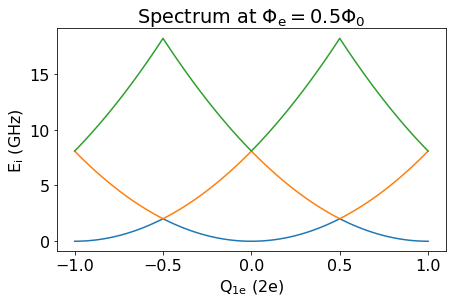

In [45]:
for i in range(3):
    plt.plot(x,Q1e_sweep[i]-Q1e_sweep[0]*0)
plt.title("Spectrum at $\Phi_e=0.5\Phi_0$")
plt.xlabel("$Q_{1e}$ (2e)")
plt.ylabel("$E_i$ (GHz)")

Ok lets look at the coupler strength and minimum gap as a function of the external flux:

In [46]:
hamil.setParameterValues('lse',0.1,'l1',0.15,'Ca',60,'Jc',1.5,'Cg1',1,'C1',7.7,'Q1e',0.5,'phie',0.0)
spec = [
    hamil.sweepSpec('Q1e',0.4999,0.5001,3),
    hamil.sweepSpec('phie',-0.5,0.5,201)
]

# Configure the items to be evaluated
evals = [
    hamil.evalSpec('getHamiltonian',True,None),
    hamil.evalSpec('getChargingEnergies',False,None,node=1),
    hamil.evalSpec('getJosephsonEnergies',False,None,edge=(0,1))
]

st = time.time()
sweep = hamil.paramSweep(spec,eval_spec=evals)
print ("Elapsed: %f" % (time.time()-st))

Elapsed: 4.663763


Text(0.5, 1.0, 'Coupling Strength at $Q_{1e} = e$')

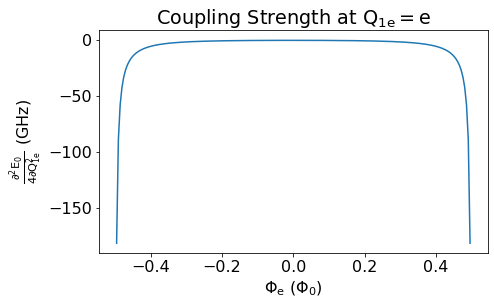

In [47]:
plt.plot(hamil.getParameterSweep('phie')[1:-1],diff2(sweep,'phie','Q1e')[1:-1]/4)
plt.ylabel("$\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}$ (GHz)")
plt.xlabel("$\\Phi_e$ ($\\Phi_0$)")
plt.title("Coupling Strength at $Q_{1e} = e$")

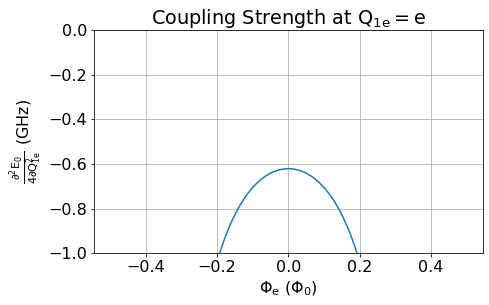

In [48]:
plt.plot(hamil.getParameterSweep('phie')[1:-1],diff2(sweep,'phie','Q1e')[1:-1]/4)
plt.ylabel("$\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}$ (GHz)")
plt.xlabel("$\\Phi_e$ ($\\Phi_0$)")
plt.title("Coupling Strength at $Q_{1e} = e$")
plt.ylim((-1,0))
plt.grid()

Text(0.5, 1.0, 'Coupler Energy Gaps at $Q_{1e}=e$')

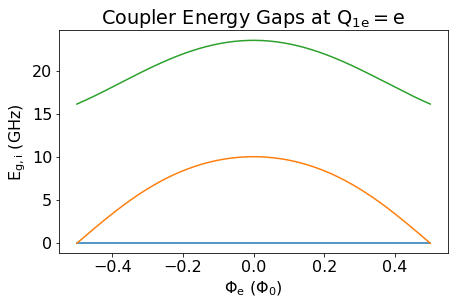

In [49]:
x,E,v = hamil.getSweep(sweep,'phie',{'Q1e':0.5})
for i in range(3):
    plt.plot(x,E[i]-E[0])
plt.xlabel("$\\Phi_e$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")
plt.title("Coupler Energy Gaps at $Q_{1e}=e$")

In [50]:
hamil.setParameterValues('lse',0.1,'l1',0.15,'Ca',60,'Jc',1.5,'Cg1',1,'C1',7.7,'Q1e',0.5,'phie',0.0)
spec = [
    hamil.sweepSpec('Q1e',-0.0001,0.0001,3),
    hamil.sweepSpec('phie',-0.5,0.5,201)
]

# Configure the items to be evaluated
evals = [
    hamil.evalSpec('getHamiltonian',True,None),
    hamil.evalSpec('getChargingEnergies',False,None,node=1),
    hamil.evalSpec('getJosephsonEnergies',False,None,edge=(0,1))
]

st = time.time()
sweep = hamil.paramSweep(spec,eval_spec=evals)
print ("Elapsed: %f" % (time.time()-st))

Elapsed: 4.374094


Text(0.5, 1.0, 'Coupling Strength at $Q_{1e} = 0$')

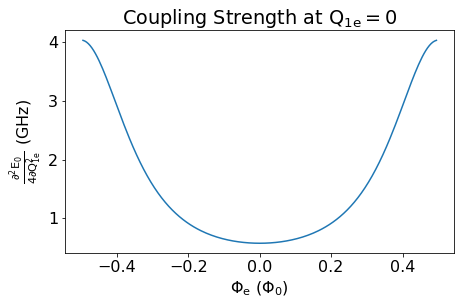

In [51]:
plt.plot(hamil.getParameterSweep('phie')[1:-1],diff2(sweep,'phie','Q1e')[1:-1]/4)
plt.ylabel("$\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}$ (GHz)")
plt.xlabel("$\\Phi_e$ ($\\Phi_0$)")
plt.title("Coupling Strength at $Q_{1e} = 0$")

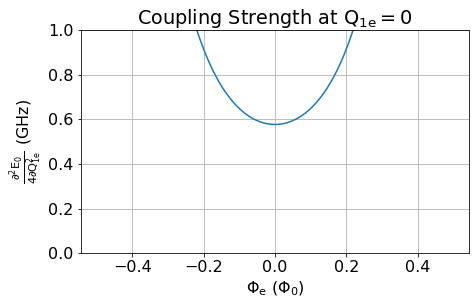

In [52]:
plt.plot(hamil.getParameterSweep('phie')[1:-1],diff2(sweep,'phie','Q1e')[1:-1]/4)
plt.ylabel("$\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}$ (GHz)")
plt.xlabel("$\\Phi_e$ ($\\Phi_0$)")
plt.title("Coupling Strength at $Q_{1e} = 0$")
plt.ylim((0,1))
plt.grid()

Text(0.5, 1.0, 'Coupler Energy Gaps at $Q_{1e}=e$')

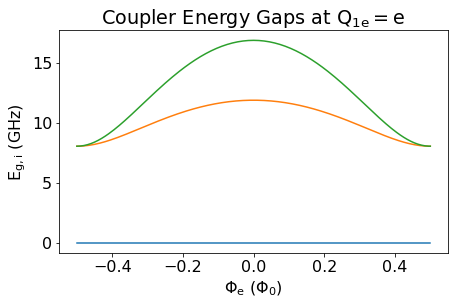

In [53]:
x,E,v = hamil.getSweep(sweep,'phie',{'Q1e':0.0})
for i in range(3):
    plt.plot(x,E[i]-E[0])
plt.xlabel("$\\Phi_e$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")
plt.title("Coupler Energy Gaps at $Q_{1e}=e$")

We see that the small $E_J$ we are aiming for now sets the minimum achievable coupling strength, which is a positive, but it now sets the maximum minimum-gap of the coupler spectrum, which is highly undesireable. Therefore the first thing to try is to increase $E_J$ to set a new minimum that is an acceptable turn-off point for the coupling term (i.e. at the beginning of the anneal).

In [54]:
hamil.setParameterValues('lse',0.2,'l1',0.15,'Ca',60,'Jc',1.5,'Cg1',1,'C1',7.7,'Q1e',0.5,'phie',0.0)
spec = [
    hamil.sweepSpec('Q1e',0.4999,0.5001,3),
    hamil.sweepSpec('phie',-0.5,0.5,201)
]

# Configure the items to be evaluated
evals = [
    hamil.evalSpec('getHamiltonian',True,None),
    hamil.evalSpec('getChargingEnergies',False,None,node=1),
    hamil.evalSpec('getJosephsonEnergies',False,None,edge=(0,1))
]

st = time.time()
sweep = hamil.paramSweep(spec,eval_spec=evals)
print ("Elapsed: %f" % (time.time()-st))

Elapsed: 4.304694


Text(0.5, 1.0, 'Coupling Strength at $Q_{1e} = e$')

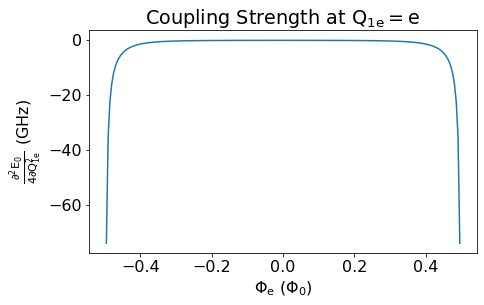

In [55]:
plt.plot(hamil.getParameterSweep('phie')[1:-1],diff2(sweep,'phie','Q1e')[1:-1]/4)
plt.ylabel("$\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}$ (GHz)")
plt.xlabel("$\\Phi_e$ ($\\Phi_0$)")
plt.title("Coupling Strength at $Q_{1e} = e$")

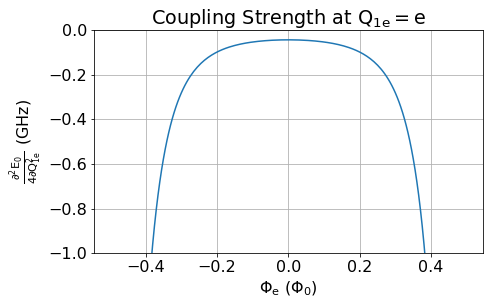

In [56]:
plt.plot(hamil.getParameterSweep('phie')[1:-1],diff2(sweep,'phie','Q1e')[1:-1]/4)
plt.ylabel("$\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}$ (GHz)")
plt.xlabel("$\\Phi_e$ ($\\Phi_0$)")
plt.title("Coupling Strength at $Q_{1e} = e$")
plt.ylim((-1,0))
plt.grid()

Text(0.5, 1.0, 'Coupler Energy Gaps at $Q_{1e}=e$')

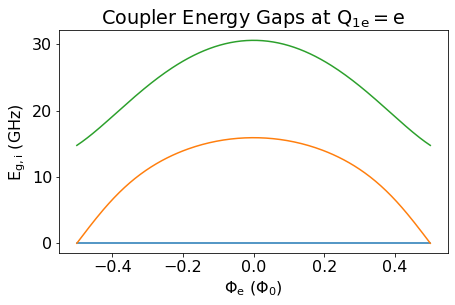

In [57]:
x,E,v = hamil.getSweep(sweep,'phie',{'Q1e':0.5})
for i in range(3):
    plt.plot(x,E[i]-E[0])
plt.xlabel("$\\Phi_e$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")
plt.title("Coupler Energy Gaps at $Q_{1e}=e$")

In [58]:
hamil.setParameterValues('lse',0.2,'l1',0.15,'Ca',60,'Jc',1.5,'Cg1',1,'C1',7.7,'Q1e',0.5,'phie',0.0)
spec = [
    hamil.sweepSpec('Q1e',-0.0001,0.0001,3),
    hamil.sweepSpec('phie',-0.5,0.5,201)
]

# Configure the items to be evaluated
evals = [
    hamil.evalSpec('getHamiltonian',True,None),
    hamil.evalSpec('getChargingEnergies',False,None,node=1),
    hamil.evalSpec('getJosephsonEnergies',False,None,edge=(0,1))
]

st = time.time()
sweep = hamil.paramSweep(spec,eval_spec=evals)
print ("Elapsed: %f" % (time.time()-st))

Elapsed: 4.573112


Text(0.5, 1.0, 'Coupling Strength at $Q_{1e} = 0$')

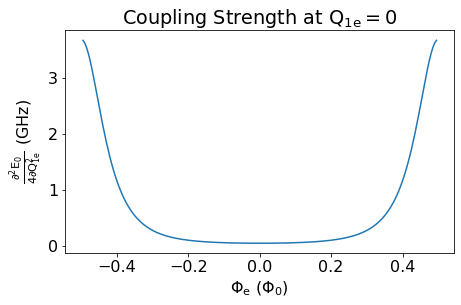

In [59]:
plt.plot(hamil.getParameterSweep('phie')[1:-1],diff2(sweep,'phie','Q1e')[1:-1]/4)
plt.ylabel("$\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}$ (GHz)")
plt.xlabel("$\\Phi_e$ ($\\Phi_0$)")
plt.title("Coupling Strength at $Q_{1e} = 0$")

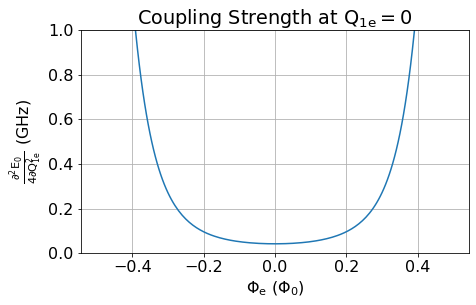

In [60]:
plt.plot(hamil.getParameterSweep('phie')[1:-1],diff2(sweep,'phie','Q1e')[1:-1]/4)
plt.ylabel("$\\frac{\\partial^2 E_{0}}{4\\partial Q_{1e}^2}$ (GHz)")
plt.xlabel("$\\Phi_e$ ($\\Phi_0$)")
plt.title("Coupling Strength at $Q_{1e} = 0$")
plt.ylim((0,1))
plt.grid()

Text(0.5, 1.0, 'Coupler Energy Gaps at $Q_{1e}=0$')

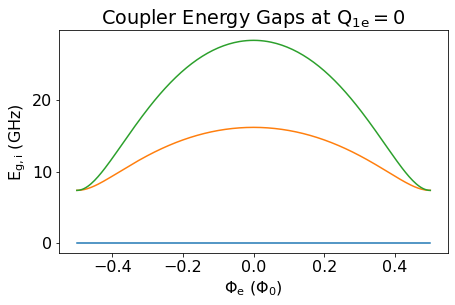

In [61]:
x,E,v = hamil.getSweep(sweep,'phie',{'Q1e':0.0})
for i in range(3):
    plt.plot(x,E[i]-E[0])
plt.xlabel("$\\Phi_e$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")
plt.title("Coupler Energy Gaps at $Q_{1e}=0$")

We see that by doubling the junction area, the maximum $E_J$ sets a minimum value of coupling energy close to zero. The flux would then need to be increased to a maximum value determined by the minimum gap condition, which also sets the maximum achievable coupling strength.

Although we have alleviated charge noise sensitivity, we have now introduced flux noise sensitivity due to the high slope at the ideal point described above. This can be mitigated by making the junction smaller, but decreases the on-off ratio as well as the minimum gap.

## Effect of Capacitively Coupled Resonator

Now we can observe what happens if we couple a linear resonator to the system, as a possible way to measure the variable capacitance of the Averin coupler.

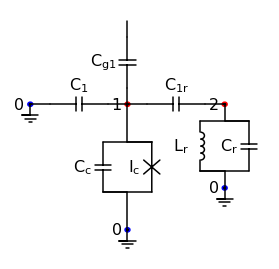

In [62]:
rcircuit = circuit.coupleLinearResonator("r",1,d=['right','down'])
rcircuit.drawCircuit(inline=True)

We see the Hamiltonian is now more complicated:

In [63]:
rcircuit.getQuantumHamiltonian()

Matrix([[-0.5*I_{c}*(1.0*D^{\dagger}_{1} + 1.0*D_{1}) + (0.5*C_{1r}*Q_{2}/(-C_{1r}**2 + (C_{1r} + C_{r})*(C_{1r} + C_{1} + C_{c} + C_{g1})) + 0.5*(C_{1r} + C_{r})*(Q_{1e} + Q_{1})/(-C_{1r}**2 + (C_{1r} + C_{r})*(C_{1r} + C_{1} + C_{c} + C_{g1})))*(Q_{1e} + Q_{1}) + (0.5*C_{1r}*(Q_{1e} + Q_{1})/(-C_{1r}**2 + (C_{1r} + C_{r})*(C_{1r} + C_{1} + C_{c} + C_{g1})) + 0.5*(C_{1r} + C_{1} + C_{c} + C_{g1})*Q_{2}/(-C_{1r}**2 + (C_{1r} + C_{r})*(C_{1r} + C_{1} + C_{c} + C_{g1})))*Q_{2} + 0.5*\Phi_{2}**2/L_{r}]])

### Single Junction Device

Now following the procedure outlined in `resonator-example.ipynb`, we initialise the Hamiltonian builder including the subsystem.

Since the capacitive loading effect of the resonator on the qubit will be significant, we effectively subtract the coupling capacitance value from $C_1$ to keep the device in the region of interest. This is a good approximation as long as the resonator capacitance is much larger than the coupling capacitance.

In [64]:
# Setup Hamiltonian
hamil = HamilSpec(circuit,include_subsystem="r")
hamil.setTruncation(1,20,"charge")

# Create new symbols
Jc, Ca, lse, l1, phie = sy.symbols("J_c C_a l_{se} l_1 \\Phi_e")

# Add the parameters
name_map = {
    "Jc":Jc,
    "Ca":Ca,
    "lse":lse,
    "l1":l1,
    "phie":phie
}

# Replace capacitors
hamil.addParameterisation("Cc",lse*l1*Ca,name_map)

# Replace JJs
hamil.addParameterisation("Ic",sy.cos(sy.pi*phie)*lse*l1*Jc,name_map)

# Generate operators and register parameterisations
hamil.prepareOperators()

# Configure diagonaliser
hamil.setDiagConfig(get_vectors=True,eigvalues=20)

# Configure the parameter sweep
spec = [
    hamil.sweepSpec('Q1e',-1,1,101)
]

# Configure the items to be evaluated
evals = [
    hamil.evalSpec('getHamiltonian',True,None),
    hamil.evalSpec('getResonatorResponse',False,"getHamiltonian",eval_dp=True)
]

Using existing PyCQED tmp output root directory '/tmp/.pycqed/'.


In [65]:
# Set the parameter values
hamil.setParameterValues(
    'lse',0.1,
    'l1',0.15,
    'Ca',60,
    'Jc',1.5,
    'Cg1',1,
    'C1',5.7,
    'Cr',400.0*1.2,
    'Lr',1000.0*1.2,
    'C1r',2.0,
    'Q1e',0.0,
    'phie',0.0
)

# Do the sweep
sweep = hamil.paramSweep(spec,eval_spec=evals,timesweep=True)

Parameter Sweep Duration:
  Initialization:	0.065 s
  Loop duration:	2.565 s
  Avg iteration:	0.025 s


First let's compare the bare spectrum vs the dressed spectrum:

In [66]:
x,EV,v = hamil.getSweep(sweep,'Q1e',{},evaluable='getHamiltonian')
E = EV[:,0]
V = EV[:,1]

Text(0.5, 1.0, 'Ground State')

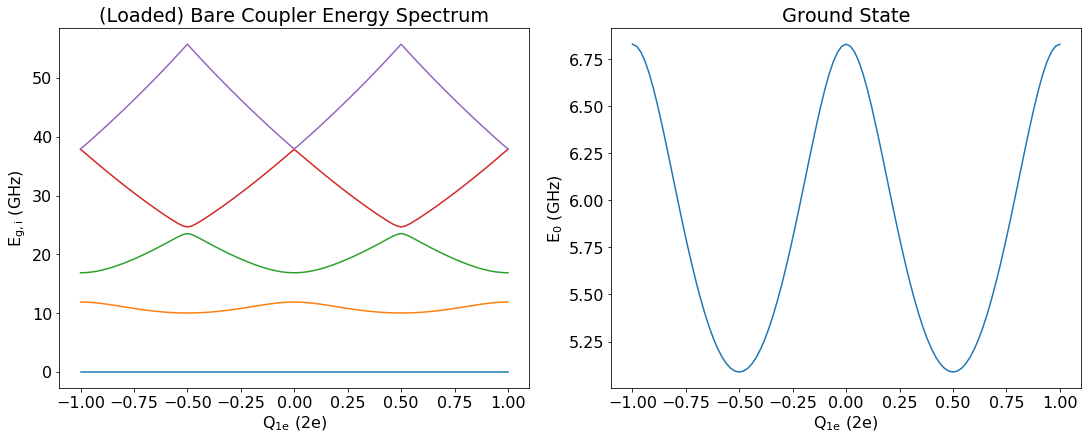

In [67]:
fig, ax = plt.subplots(ncols=2,nrows=1,constrained_layout=True,figsize=(15,6))
ax1 = ax[0]
ax2 = ax[1]

# Energy spectrum
for i in range(5):
    y = E[i]-E[0]
    ax1.plot(x,y)
ax1.set_xlabel("$Q_{1e}$ ($2e$)")
ax1.set_ylabel("$E_{g,i}$ (GHz)")
ax1.set_title("(Loaded) Bare Coupler Energy Spectrum")

# Ground state
y = E[1]
ax2.plot(x,y)
ax2.set_xlabel("$Q_{1e}$ ($2e$)")
ax2.set_ylabel("$E_{0}$ (GHz)")
ax2.set_title("Ground State")

In [68]:
x,Erwa,v = hamil.getSweep(sweep,'Q1e',{},evaluable='getResonatorResponse')
Edressed = util.getCircuitLambShift(Erwa)

Text(0.5, 1.0, '(Loaded) Dressed Coupler Energy Spectrum')

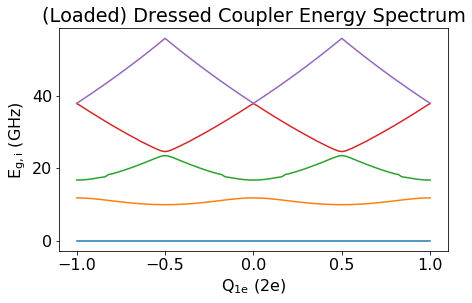

In [69]:
# Dressed energy spectrum
for i in range(5):
    y = Edressed[i]
    plt.plot(x,y)
plt.xlabel("$Q_{1e}$ ($2e$)")
plt.ylabel("$E_{g,i}$ (GHz)")
plt.title("(Loaded) Dressed Coupler Energy Spectrum")

We can see some evidence of coupler-resonator interaction in the second (green) energy gap, however the resonator likely lies in the tunneling gap, so we will not see an avoided crossing. We can observe more closely what is happening by solving the whole system later on.

Now let's get the resonator modulation:

In [70]:
# Get the loaded bare resonator frequency
wr = hamil.dpnp['w']

# Get the modulated resonator frequency
Eres = util.getResonatorShift(Erwa)

Text(0.5, 1.0, 'Resonator Modulation Against $Q_{1e}$')

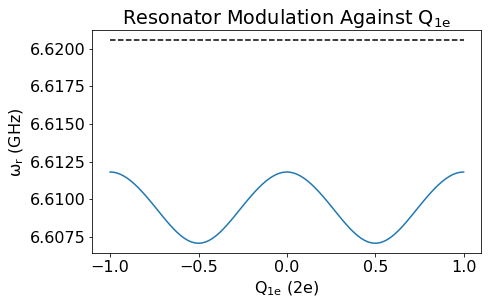

In [71]:
plt.plot(x,Eres[0,0])
plt.plot([x[0],x[-1]],[wr,wr],"k--")
plt.xlabel("$Q_{1e}$ ($2e$)")
plt.ylabel("$\omega_{r}$ (GHz)")
plt.title("Resonator Modulation Against $Q_{1e}$")

The fact that the resonator frequency is pulled downwards is understood, since the energy gap is always larger than the resonator energy here. We also seem to get a decent modulation depth, about 10 MHz for the given coupling capacitance of 5 fF.

### DC-SQUID Device

Now we replace the single junction with a two junctions of the same size as before, again assuming perfect symmetry.

In [72]:
# Set the parameter values
hamil.setParameterValues(
    'Q1e',0.0,
    'lse',0.2,
)

# Configure the parameter sweep
spec = [
    hamil.sweepSpec('phie',-0.4999,0.4999,101)
]

# Configure the items to be evaluated
evals = [
    hamil.evalSpec('getHamiltonian',True,None),
    hamil.evalSpec('getResonatorResponse',False,"getHamiltonian",eval_dp=True)
]

# Do the sweep
sweep = hamil.paramSweep(spec,eval_spec=evals,timesweep=True)

Parameter Sweep Duration:
  Initialization:	0.034 s
  Loop duration:	2.751 s
  Avg iteration:	0.027 s


Text(0.5, 1.0, 'Ground State')

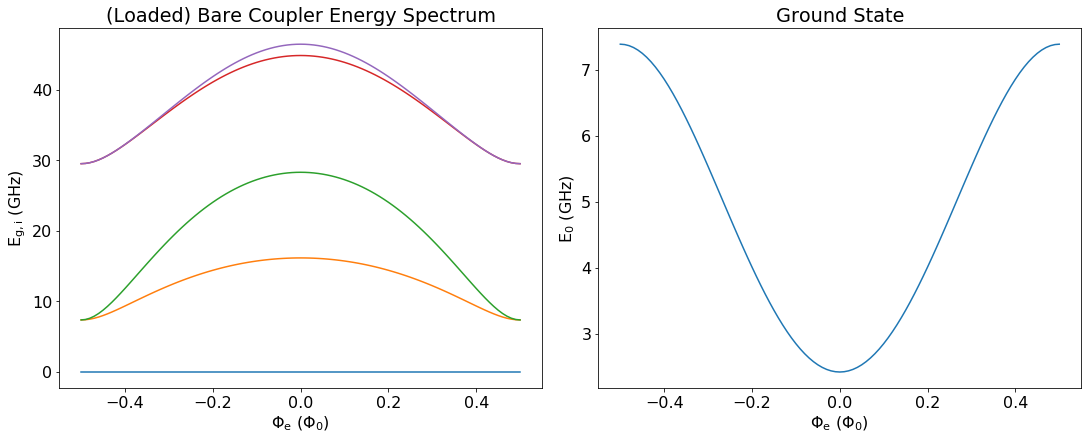

In [73]:
x,EV,v = hamil.getSweep(sweep,'phie',{},evaluable='getHamiltonian')
E = EV[:,0]
V = EV[:,1]

fig, ax = plt.subplots(ncols=2,nrows=1,constrained_layout=True,figsize=(15,6))
ax1 = ax[0]
ax2 = ax[1]

# Energy spectrum
for i in range(5):
    y = E[i]-E[0]
    ax1.plot(x,y)
ax1.set_xlabel("$\\Phi_{e}$ ($\\Phi_0$)")
ax1.set_ylabel("$E_{g,i}$ (GHz)")
ax1.set_title("(Loaded) Bare Coupler Energy Spectrum")

# Ground state
y = E[1]
ax2.plot(x,y)
ax2.set_xlabel("$\\Phi_{e}$ ($\\Phi_0$)")
ax2.set_ylabel("$E_{0}$ (GHz)")
ax2.set_title("Ground State")

In [74]:
x,Erwa,v = hamil.getSweep(sweep,'phie',{},evaluable='getResonatorResponse')

# Get the loaded bare resonator frequency
wr = hamil.dpnp['w']

# Get the modulated resonator frequency
Eres = util.getResonatorShift(Erwa)

Text(0.5, 1.0, 'Resonator Modulation Against $\\Phi_{e}$ at $Q_{1e}=0$')

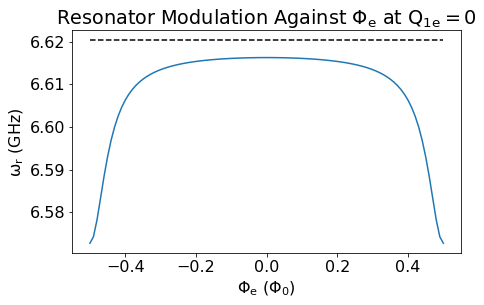

In [75]:
plt.plot(x,Eres[0,0])
plt.plot([x[0],x[-1]],[wr,wr],"k--")
plt.xlabel("$\\Phi_{e}$ ($\\Phi_0$)")
plt.ylabel("$\omega_{r}$ (GHz)")
plt.title("Resonator Modulation Against $\\Phi_{e}$ at $Q_{1e}=0$")

In [76]:
# Set the parameter values
hamil.setParameterValues(
    'Q1e',0.5
)

# Configure the parameter sweep
spec = [
    hamil.sweepSpec('phie',-0.4999,0.4999,101)
]

# Configure the items to be evaluated
evals = [
    hamil.evalSpec('getHamiltonian',True,None),
    hamil.evalSpec('getResonatorResponse',False,"getHamiltonian",eval_dp=True)
]

# Do the sweep
sweep = hamil.paramSweep(spec,eval_spec=evals,timesweep=True)

Parameter Sweep Duration:
  Initialization:	0.044 s
  Loop duration:	2.634 s
  Avg iteration:	0.026 s


Text(0.5, 1.0, 'Ground State')

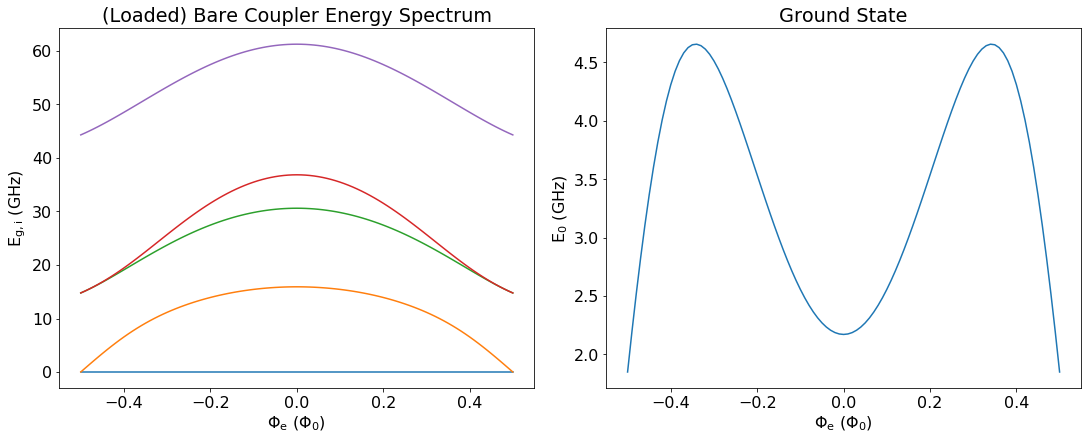

In [77]:
x,EV,v = hamil.getSweep(sweep,'phie',{},evaluable='getHamiltonian')
E = EV[:,0]
V = EV[:,1]

fig, ax = plt.subplots(ncols=2,nrows=1,constrained_layout=True,figsize=(15,6))
ax1 = ax[0]
ax2 = ax[1]

# Energy spectrum
for i in range(5):
    y = E[i]-E[0]
    ax1.plot(x,y)
ax1.set_xlabel("$\\Phi_{e}$ ($\\Phi_0$)")
ax1.set_ylabel("$E_{g,i}$ (GHz)")
ax1.set_title("(Loaded) Bare Coupler Energy Spectrum")

# Ground state
y = E[1]
ax2.plot(x,y)
ax2.set_xlabel("$\\Phi_{e}$ ($\\Phi_0$)")
ax2.set_ylabel("$E_{0}$ (GHz)")
ax2.set_title("Ground State")

Text(0.5, 1.0, 'Resonator Modulation Against $\\Phi_{e}$ at $Q_{1e}=e$')

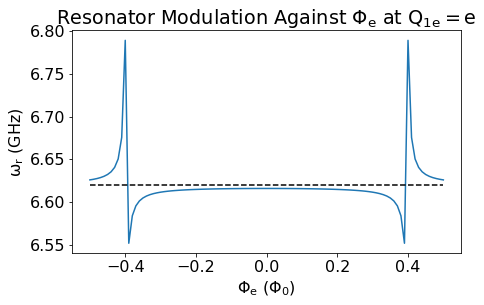

In [78]:
x,Erwa,v = hamil.getSweep(sweep,'phie',{},evaluable='getResonatorResponse')

# Get the loaded bare resonator frequency
wr = hamil.dpnp['w']

# Get the modulated resonator frequency
Eres = util.getResonatorShift(Erwa)

plt.plot(x,Eres[0,0])
plt.plot([x[0],x[-1]],[wr,wr],"k--")
plt.xlabel("$\\Phi_{e}$ ($\\Phi_0$)")
plt.ylabel("$\omega_{r}$ (GHz)")
plt.title("Resonator Modulation Against $\\Phi_{e}$ at $Q_{1e}=e$")

## Effect of Junction Asymmetry

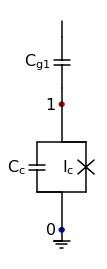

In [79]:
circuit = CircuitSpec("Averin Coupler")
circuit.addBranch(["Cc","Ic"],"up",0,False,lead_len=1.5)
circuit.addChargeBias('up',1,lead_len=1)
circuit.drawCircuit(inline=True)

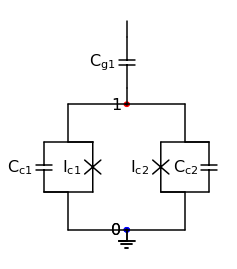

In [80]:
circuit = CircuitSpec("Averin Coupler")
circuit.addBranch(["Cc1","Ic1"],"up",0,False,lead_len=1.5,arm_len=0.6)
circuit.addBranch(["Cc2","Ic2"],"down",1,True,lead_len=1.5,arm_len=0.6)
circuit.addChargeBias('up',1,lead_len=1)
circuit.drawCircuit(inline=True)

### Effective Capacitance Model

Now we can compute the effective capacitance seen by the resonator assuming that all the modulations is due to a tuneable capacitance. This tuneable capacitance can be expressed as

$$C_\mathrm{eff}(Q_{1e}) = \frac{C_{1r}(1-\omega_r(Q_{1e})^2 L_r C_r)}{\omega_r(Q_{1e})^2 L_r (C_r + C_{1r}) - 1}$$

In [ ]:
C1r = hamil.getParameterValue("C1r")*1e-15
Cr = hamil.getParameterValue("Cr")*1e-15
Lr = hamil.getParameterValue("Lr")*1e-12

In [ ]:
Ceff = C1r*(1 - Eres[0,0]**2*1e18*Cr*Lr)/(Eres[0,0]**2*1e18*Lr*(Cr+C1r) - 1)*1e15

In [ ]:
plt.plot(x,Ceff)
#plt.plot([x[0],x[-1]],[wr,wr],"k--")
plt.xlabel("$Q_{1e}$ ($2e$)")
plt.ylabel("$C_\\mathrm{eff}$ (fF)")

## Effect of Galvanically Coupled Resonator

Now let's see what happens when we couple a resonator galvanically to the coupler. If the resonator is connected as before, the circuit will effectively be a RF-SQUID qubit due to the inductive loop formed. In this case the charge bias will have no effect as it shifts the potential of the entire loop. We can break the loop by including a capacitor between the resonator and ground:

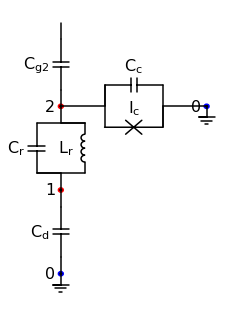

In [81]:
circuit = CircuitSpec("CPB")
circuit.addBranch(["Cd"],"up",0,False)
circuit.addBranch(["Lr","Cr"],"up",1,False)
circuit.addBranch(["Cc","Ic"],"right",2,True,lead_len=1.5)
circuit.addChargeBias('up',2,lead_len=1)
circuit.drawCircuit(inline=True)

In [82]:
circuit.getQuantumHamiltonian()

Matrix([[-0.5*I_{c}*(1.0*D^{\dagger}_{2} + 1.0*D_{2}) + (-0.5*\Phi_{1}/L_{r} + 0.5*\Phi_{2}/L_{r})*\Phi_{2} + (0.5*\Phi_{1}/L_{r} - 0.5*\Phi_{2}/L_{r})*\Phi_{1} + (0.5*C_{r}*Q_{1}/(-C_{r}**2 + (C_{d} + C_{r})*(C_{c} + C_{g2} + C_{r})) + 0.5*(C_{d} + C_{r})*(Q_{2e} + Q_{2})/(-C_{r}**2 + (C_{d} + C_{r})*(C_{c} + C_{g2} + C_{r})))*(Q_{2e} + Q_{2}) + (0.5*C_{r}*(Q_{2e} + Q_{2})/(-C_{r}**2 + (C_{d} + C_{r})*(C_{c} + C_{g2} + C_{r})) + 0.5*(C_{c} + C_{g2} + C_{r})*Q_{1}/(-C_{r}**2 + (C_{d} + C_{r})*(C_{c} + C_{g2} + C_{r})))*Q_{1}]])

In [83]:
hamil = HamilSpec(circuit,mode="node")
hamil.setTruncation(1,10,"charge")
hamil.setTruncation(2,10,"charge")
hamil.prepareOperators()
hamil.params.getParameterNamesList()

Using existing PyCQED tmp output root directory '/tmp/.pycqed/'.


['Cd', 'Cr', 'Lr', 'Cc', 'Ic', 'Cg2', 'Q2e']

In [84]:
# Fabrication parameters
Ca = 60.0 # fF/um^2
Jc = 1.0  # uA/um^2
Aj = 0.1*0.2#0.4**2 # um^2

# Configure the parameter sweep
spec = [
    hamil.sweepSpec('Q2e',-1,1,101)
]

# Set the parameter values
hamil.setParameterValues('Ic',Jc*Aj,'Cc',Ca*Aj,'Cg2',5.0,'Cr',400.0,'Lr',1000.0,'Q2e',0.0,'Cd',1.0)

sweep = hamil.paramSweep(spec)

Text(0.5, 1.0, 'Ground State')

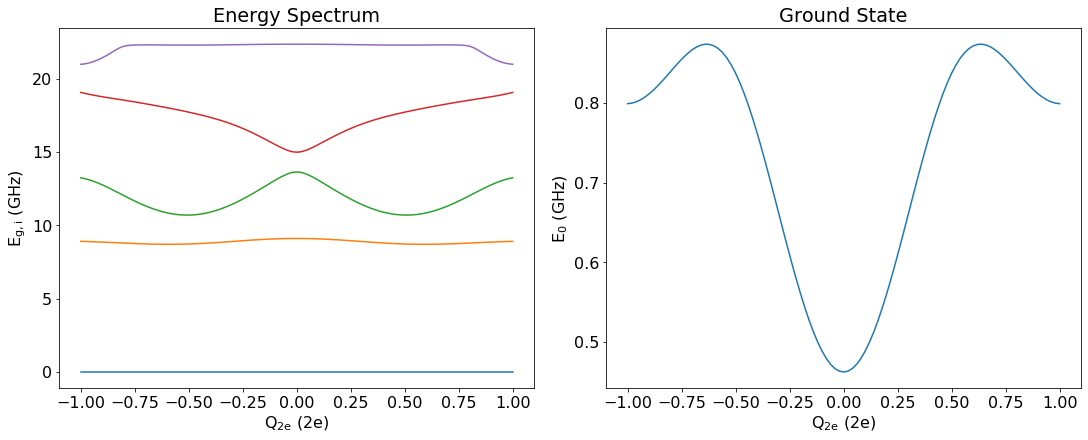

In [85]:
x,Q2e_sweep,v = hamil.getSweep(sweep,'Q2e',{})

fig, ax = plt.subplots(ncols=2,nrows=1,constrained_layout=True,figsize=(15,6))
ax1 = ax[0]
ax2 = ax[1]

# Energy spectrum
for i in range(5):
    y = Q2e_sweep[i]-Q2e_sweep[0]
    ax1.plot(x,y)
ax1.set_xlabel("$Q_{2e}$ ($2e$)")
ax1.set_ylabel("$E_{g,i}$ (GHz)")
ax1.set_title("Energy Spectrum")

# Ground state
y = Q2e_sweep[0]
ax2.plot(x,y)
ax2.set_xlabel("$Q_{2e}$ ($2e$)")
ax2.set_ylabel("$E_{0}$ (GHz)")
ax2.set_title("Ground State")

Text(0.5, 1.0, 'Ground and Excited State')

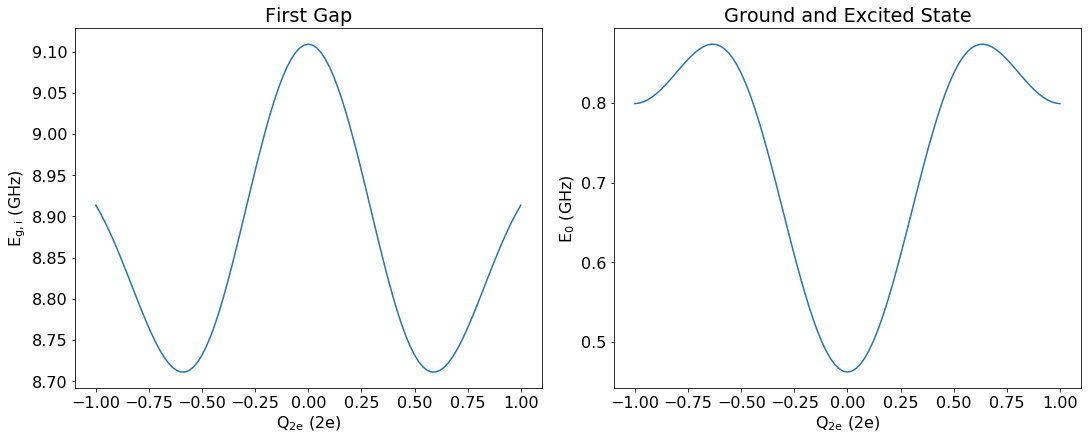

In [86]:
x,Q2e_sweep,v = hamil.getSweep(sweep,'Q2e',{})

fig, ax = plt.subplots(ncols=2,nrows=1,constrained_layout=True,figsize=(15,6))
ax1 = ax[0]
ax2 = ax[1]

# Energy spectrum
for i in range(1):
    y = Q2e_sweep[i+1]-Q2e_sweep[0]
    ax1.plot(x,y)
ax1.set_xlabel("$Q_{2e}$ ($2e$)")
ax1.set_ylabel("$E_{g,i}$ (GHz)")
ax1.set_title("First Gap")

# Ground state
y0 = Q2e_sweep[0]
#y1 = Q2e_sweep[1]
ax2.plot(x,y0,label="0")
#ax2.plot(x,y1,label="1")
ax2.set_xlabel("$Q_{2e}$ ($2e$)")
ax2.set_ylabel("$E_{0}$ (GHz)")
ax2.set_title("Ground and Excited State")

Perhaps it is possible for the resonant frequency to be sensitive to the ground state curvature by ensuring that the resonator levels interact very weakly with coupler levels. This way the resonator energy level should be flat, and the resulting gap will be mostly dependent on the ground state energy variation.